In [1]:
import scanpy as sc
import os, glob
import numpy as np
import nrrd
import matplotlib.pyplot as plt
import plotting_help_py37 as ph
import orn_pn_matching_imaging as im
import orn_pn_matching as opm
import tifffile as tiff

In [2]:
from PIL import Image
from PIL.TiffTags import TAGS

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [4]:
from skimage import measure

### Requirements:
1. PN dendrite ROIs do not exceed the top and bottom slices of AL mask
2. the centroids of left and right AL do not cross midline

In [37]:
fn = '#14_30h_20230728_20x_5.tif'
ch_pn = 0
rec = im.AntennaLobe(folder='./../../1_Data/confocal/3_pn/WT/test/', filename=fn[:-4], ch_pn=ch_pn)

IndexError: list index out of range

In [48]:
gts = [
    '#14_30h', 
      ]
labels = ['DC4-30h',]
colors = ph.colors_high_contrast()
parent_folder = './../../1_Data/confocal/3_pn/WT/test/'

recss = []
for gt in gts:
    recs = im.get_recs_AntennaLobe(gt, parent_folder=parent_folder, multifolders=True,)
    recss.append(recs)

In [49]:
recs = recss[0]
ys = []
for rec in recs:
    for i in range(2):
        if len(rec.ds_pnden[i]):
            hist, bin_edges = np.histogram(rec.ds_pnden[i], bins=np.linspace(0,20,20))
            ys.append(hist)
x = (bin_edges[1:]+bin_edges[:-1])/2.

In [126]:
im.get_recs_AntennaLobe(genotype, parent_folder='./', ch_pn=0, multifolders=False

[None,
 array([[[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0, 255, ...,   0,   0,   0],
         ...,
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0]],
 
        ...,
 
        [[  0,   0,   0, ...,   0,   0,   0],
         [  0,   0,   0, ...,   0,   0,   0],
       

In [43]:
rec = recss[0][0]
hist(rec.ds_pnden[1], bins=np.linspace(0,20))

TypeError: 'numpy.ndarray' object is not callable

In [134]:
hist, bin_edges = np.histogram(rec.ds_pnden[1], bins=np.linspace(0,20,20))

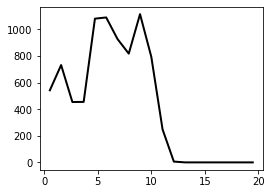

In [47]:
ax = ph.large_ax([4,3])
for y in ys:
    ax.plot(x, y, lw=.5, c=ph.grey5)
ax.plot(x, np.nanmean(ys, axis=0), lw=2, c='black')

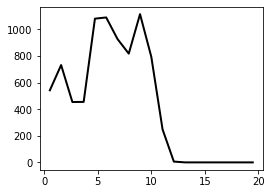

In [50]:
ax = ph.large_ax([4,3])
for y in ys:
    ax.plot(x, y, lw=.5, c=ph.grey5)
ax.plot(x, np.nanmean(ys, axis=0), lw=2, c='black')

In [109]:
self = rec
pnmask = self.pnmask
ds = [[],[]]
for i in range(2):
    pnmask_bool = (pnmask == i+1)
    if pnmask_bool.sum():
        sig = self.tif * pnmask_bool
        sig_sum = np.sum(sig)
        x_pnc = np.sum(np.sum(np.sum(sig, axis=0), axis=1) * np.arange(self.X)) / sig_sum
        side = 0 if (x_pnc < self.X/2.) else 1
        if self.pndenmask[side] is not None:
            pndenmask_bool = (self.pndenmask[side] > 1)
            sig = pnmask_bool * pndenmask_bool
            ds_ = []
            for z in np.arange(self.ncadz[1][0], self.ncadz[1][1]+1):
                if np.sum(sig[:,:,z]):
                    ys, xs = np.nonzero(sig[:,:,z])     # notice flip of x and y axis here
                    xs = xs * self.xf
                    ys = ys * self.yf
                    z0_, z1_ = z, z-1
                    z0, z1 = (z0_, z1_) if (self.ncad[side][z0_].ab > self.ncad[side][z1_].ab) else (z1_, z0_)
                    theta = np.arctan(self.zf / ((self.ncad[side][z0].ab - self.ncad[side][z1].ab)/2))
                    for i in range(len(xs)):
                        d0 = np.min(np.sqrt((self.ncad[side][z].xb-xs[i])**2+(self.ncad[side][z].yb-ys[i])**2))
                        d_ = np.min([d0 * np.sin(theta), (self.ncadz[side][1]-z0)*self.zf])
                        ds_.append(d_)
            ds[side] = ds_

In [111]:
ds

[[],
 [1.9931708012930944,
  2.1355120633197253,
  1.9393721531781725,
  2.085388759435433,
  7.2403555393297685,
  7.331669806905069,
  8.383988290441795,
  8.465467253459051,
  7.354680204184356,
  7.444592314385079,
  8.34990946157173,
  8.426706325396834,
  8.505293252796353,
  8.585621088842993,
  8.258345091416617,
  8.328380880839694,
  8.400347307539707,
  8.47419518431015,
  8.549875759320905,
  8.627340802437528,
  8.706542682748749,
  8.787434437604094,
  8.076024915092692,
  8.150219949188573,
  8.22631353369461,
  8.304253478349814,
  8.383988290441795,
  8.455481443727413,
  8.52637515220695,
  8.599140792583164,
  8.673731252967531,
  8.750099866303577,
  8.828200486815433,
  8.907987558594412,
  8.201885886245664,
  8.27495250028357,
  8.349909461571725,
  8.426706325396829,
  8.505293252796347,
  8.583160672948118,
  8.653008374467037,
  8.724717936019042,
  8.79824383278449,
  8.873540914579165,
  8.950564480960562,
  9.029270349064616,
  9.109614914402481,
  8.258345

In [85]:
z0

14

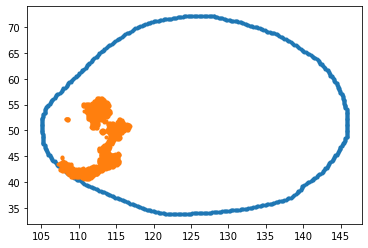

In [87]:
plot(self.ncad[side][z].xb, self.ncad[side][z].yb,'.')
plot(ys,xs,'.')

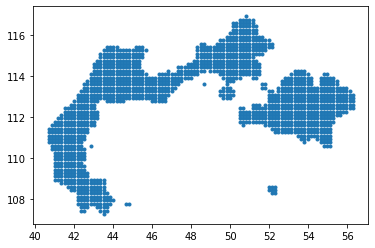

In [92]:
np.unique(ds)

array([ 0.        ,  0.15438043,  0.15438043, ..., 10.56124653,
       10.5905427 , 10.65672372])

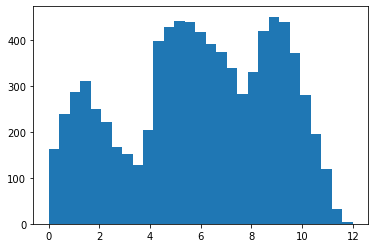

In [102]:
_ = plt.hist(ds, bins=np.linspace(0,12,30))

In [100]:
np.mean(ds)

5.191820921404696

In [33]:
pnmask_bool.shape

(512, 1024, 33)

In [38]:
np.sum(sig)

8263

In [4]:
ch_pn = 1
x_factor, y_factor, z_factor = 0.1431, 0.1431, 1 # micron/pixel

In [5]:
tif_fn = '../../1_Data/confocal/3_pn/0_analysis/'
tif_ = tiff.imread(tif_fn)
tif = np.swapaxes(np.swapaxes(tif_.T, 0, 1), 2,3)[:,:,:,ch_pn]
print(tif.shape)

(350, 668, 31)


In [6]:
Y, X, Z = tif.shape

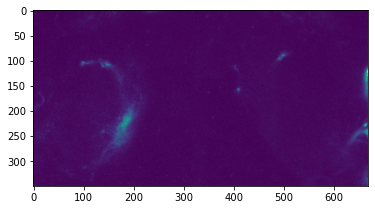

In [7]:
z = 18
imshow(tif[:,:,z])

(350, 668, 31)


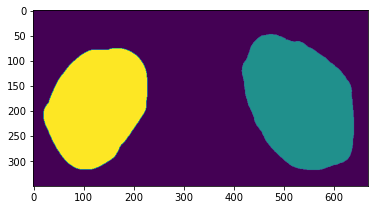

In [8]:
almask_fn = '../my_files/docs/17E11-GFP-almask.nrrd'
mask_, _ = nrrd.read(almask_fn)
almask = np.swapaxes(np.swapaxes(mask_.T, 0, 1), 1, 2)
print(almask.shape)
imshow(almask[:,:,z])
pic = almask[:,:,z]

In [9]:
mask_.shape

(668, 350, 31)

In [10]:
almask.shape

(350, 668, 31)

2
531.3490959666203 668
127.83732057416267 668


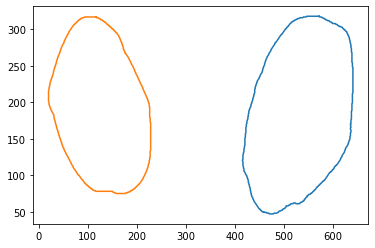

In [11]:
contours = measure.find_contours(pic, level=0)
print(len(contours))
for i in range(len(contours)):
    ct = contours[i]
    xb = ct[:,1]
    yb = ct[:,0]
    print(np.mean(xb), X)
    plot(xb, yb)

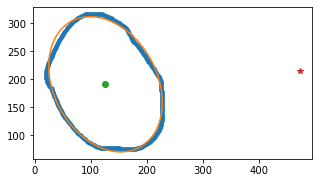

In [14]:
coeffs = im.fit_ellipse(xb, yb)
x0, y0, ap, bp, e, phi = im.cart_to_pol(coeffs)
# print('Fitted parameters:')
# print('a, b, c, d, e, f =', coeffs)
ax = ph.large_ax([5,5])
ax.plot(xb, yb, '.')     # given points
xf, yf = im.get_ellipse_pts((x0, y0, ap, bp, e, phi))
ax.plot(xf, yf)
ax.plot(x0,y0,'o')
ax.plot(x_pnc,y_pnc,'*')
# ax.plot(xb[idx],yb[idx],'o')
# ax.plot(dx,dy,'^')
ax.set_aspect('equal', 'box')

In [20]:
x0, y0, ap, bp, e, phi

(126.23579554216592,
 191.29327448274123,
 127.96325062999934,
 92.14796330031186,
 0.6938571060907697,
 2.067732394370398)

(350, 668, 31)
472.9651261250496 214.90233761778038 9.485013269301211


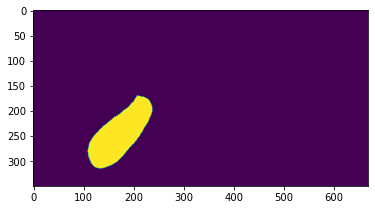

In [13]:
pnmask_fn = '../my_files/docs/17E11-GFP-pnmask.nrrd'
mask_, _ = nrrd.read(pnmask_fn)
pnmask = np.swapaxes(np.swapaxes(mask_.T, 0, 1), 1, 2)
print(pnmask.shape)
imshow(pnmask[:,:,18])
pic = pnmask[:,:,18]

mask = (pnmask == 1)
if mask.sum():
    sig = tif * mask
    sig_sum = np.sum(sig)
    x_pnc = np.sum(np.sum(np.sum(sig, axis=0), axis=1)*np.arange(X))/sig_sum
    y_pnc = np.sum(np.sum(np.sum(sig, axis=1), axis=1)*np.arange(Y))/sig_sum
    z_pnc = np.sum(np.sum(np.sum(sig, axis=0), axis=0)*np.arange(Z))/sig_sum
    print(x_pnc,y_pnc,z_pnc)

### Initializing object

In [7]:
folder = '../../1_Data/confocal/3_pn/0_analysis/'
fn = '48_30h_DC3_2'
rec = im.AntennaLobe(folder=folder, filename=fn, ch_pn=0)

(512, 1024, 40)


In [33]:
recs = im.get_recs_AntennaLobe(fn, folder, ch_pn=0)

In [8]:
pn = rec.pn[1]

In [9]:
pn.d_toncad

4.0

In [10]:
self = rec

In [24]:
pnmask = self.pnmask
for i in range(2):
    mask = (pnmask == i+1)
    if mask.sum():
        sig = self.tif * mask
        sig_sum = np.sum(sig)
        x_pnc_p = np.sum(np.sum(np.sum(sig, axis=0), axis=1) * np.arange(self.X)) / sig_sum   # sum axis 0, leave axis 1 as X
        y_pnc_p = np.sum(np.sum(np.sum(sig, axis=1), axis=1) * np.arange(self.Y)) / sig_sum   # sum axis 1, leave axis 0 as X
        z_pnc_p = np.sum(np.sum(np.sum(sig, axis=0), axis=0) * np.arange(self.Z)) / sig_sum

        side = 0 if (x_pnc_p < self.X/2.) else 1
        z0_ = np.floor(z_pnc_p).astype(int)
        z1_ = np.ceil(z_pnc_p).astype(int)
        x_pnc = x_pnc_p * self.xf
        y_pnc = y_pnc_p * self.yf
        z_pnc = z_pnc_p * self.zf
        # ncad in z0 is larger than the one in z1
        z0, z1 = (z0_, z1_) if (self.ncad[side][z0_].ab > self.ncad[side][z1_].ab) else (z1_, z0_)
        d0 =  np.min(np.sqrt((self.ncad[side][z0].xb-x_pnc)**2+(self.ncad[side][z0].yb-y_pnc)**2))
        theta = np.arctan(self.zf / ((self.ncad[side][z0].ab - self.ncad[side][z1].ab)/2))
        
        d = np.min([d0 * np.sin(theta), (self.ncadz[side][1]-z0)*self.zf])

In [18]:
z0

21

In [20]:
pic = self.almask[:,:,22]

In [26]:
x_pnc_p

812.8011549244592

In [35]:
zs_inncad = self.almask[int(y_pnc_p),int(x_pnc_p),:]
idxs = np.where(zs_inncad[z0:]==0)[0]
if len(idxs):
    z_out = idxs[0]+z0
if z_out >= self.ncadz[side][1]: # pixel is within the top layer of ncad
    d_vertical = (self.ncadz[side][1]-z0)*self.zf
else: # pixel is outside some layer of ncad
    d0_ = np.min(np.sqrt((self.ncad[side][z_out-1].xb-x_pnc)**2+(self.ncad[side][z_out-1].yb-y_pnc)**2))
    tan_theta_ = self.zf / np.abs((self.ncad[side][z_out-1].ab - self.ncad[side][z_out].ab)/2)
    d_vertical = d0_*tan_theta_ + (z_out-z0-1) * self.zf

d = np.min([d0 * np.sin(theta), d_vertical])

In [36]:
d

4.0

In [34]:
self.ncadz

array([[ 0,  0],
       [ 9, 25]])

In [27]:
pic[int(y_pnc_p),int(x_pnc_p)]

1

In [19]:
self.ncad[1][22]

In [61]:
sig_s = np.sort(sig, axis=0)
f0 = np.nanmean(sig_s[:int(len(sig)*.05)], axis=0)
print(f0)
# f0 too small

398.31950762643834


In [62]:
sig_thresh = np.nanmean(sig_s) / 2
print(sig_thresh)

2564.6201147964302


(array([3.3380e+03, 1.3495e+04, 1.1251e+04, 6.7570e+03, 4.7330e+03,
        3.8430e+03, 3.2200e+03, 2.6040e+03, 2.1290e+03, 1.8880e+03,
        1.6670e+03, 1.4560e+03, 1.2750e+03, 1.1630e+03, 9.9100e+02,
        8.4300e+02, 7.6500e+02, 7.4800e+02, 6.1100e+02, 6.2700e+02,
        6.0300e+02, 5.3400e+02, 4.8000e+02, 4.6100e+02, 4.6700e+02,
        4.6800e+02, 4.1400e+02, 4.1300e+02, 3.6700e+02, 3.2800e+02,
        3.0500e+02, 3.4600e+02, 2.8800e+02, 2.9100e+02, 2.8200e+02,
        2.5100e+02, 2.6600e+02, 2.3300e+02, 2.2800e+02, 2.4000e+02,
        2.5100e+02, 2.1700e+02, 2.0300e+02, 1.9300e+02, 1.8900e+02,
        1.8800e+02, 1.5800e+02, 1.5800e+02, 1.6100e+02, 1.3800e+02,
        1.4600e+02, 1.4400e+02, 1.2200e+02, 1.4700e+02, 1.2300e+02,
        1.3300e+02, 1.2600e+02, 1.0800e+02, 1.0100e+02, 9.0000e+01,
        9.5000e+01, 7.4000e+01, 6.7000e+01, 5.3000e+01, 7.0000e+01,
        6.0000e+01, 4.8000e+01, 6.2000e+01, 4.7000e+01, 3.0000e+01,
        2.9000e+01, 4.1000e+01, 3.3000e+01, 2.90

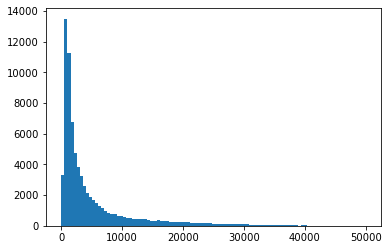

In [63]:
hist(sig,bins=np.linspace(0,50000,100))

In [138]:
ds = []
for rec in recs:
    for side in range(2):
        if rec.pn[side] is not None:
            ds.append(rec.pn[side].d_toncad)

In [139]:
ds

[6.776528983032412, 5.230856526751558, 7.975237299906442]

In [14]:
nl = al.ncad[0]
a_list = []
for z in range(len(nl)):
    if nl[z] is not None:
        a_list.append(nl[z].a)
a_list

[5.296643291895284,
 10.185143652065536,
 11.954207842926001,
 14.608968075321748,
 15.854462909857135,
 16.48788335553909,
 17.01510996027559,
 17.594996206907602,
 18.311541165152864,
 18.921530834282,
 19.450266107142692,
 20.02802003805916,
 20.77261873243981,
 20.740640282031272,
 20.741427467189432,
 20.74411937273594,
 20.7242427072794,
 20.781072624341185]

In [28]:
al.pn[1].d_toncad

1.4895213748947742

In [17]:
print(al.ncad[0][18].b, al.ncad[0][18].a)

13.186373548274624 18.311541165152864


In [18]:
al_adult = im.AntennaLobe(folder='../my_files/docs/', filename='JFRCtemplate', xyz_factors=(0.6221,0.6221,.6221),
                          ch_pn=None)

In [19]:
xf, yf, zf = 0.6221, 0.6221, 0.6221
folder = '../my_files/docs/'
filename = ''
mask1, _ = nrrd.read((glob.glob(folder + os.path.sep + filename + '*pnmask1.nrrd'))[0])
mask2, _ = nrrd.read((glob.glob(folder + os.path.sep + filename + '*pnmask2.nrrd'))[0])
mask3, _ = nrrd.read((glob.glob(folder + os.path.sep + filename + '*pnmask3.nrrd'))[0])
mask1 = np.swapaxes(np.swapaxes(mask1.T, 0, 1), 1, 2)
mask2 = np.swapaxes(np.swapaxes(mask2.T, 0, 1), 1, 2)
mask3 = np.swapaxes(np.swapaxes(mask3.T, 0, 1), 1, 2)
inds = mask2>0
mask2[inds] = mask2[inds] + 36
inds = mask3>0
mask3[inds] = mask3[inds] + 71
pnmask = np.maximum(mask1, mask2)
pnmask = np.maximum(pnmask, mask3)

In [20]:
gloms = opm.glomid_list

In [21]:
Z = 65
ds = np.zeros(100)
for i_pn in range(50):
    print(i_pn)
    for i in range(2):
        i_glom = i_pn*2+i
        mask = (pnmask == i_glom+1)
        sig = mask.astype(int)
        sig_sum = np.sum(sig)
        x_pnc = np.sum(np.sum(np.sum(sig, axis=0), axis=1) * np.arange(al_adult.X)) / sig_sum
        y_pnc = np.sum(np.sum(np.sum(sig, axis=1), axis=1) * np.arange(al_adult.Y)) / sig_sum
        sig_ = np.sum(np.sum(sig, axis=0), axis=0)[:Z]
        z_pnc = np.sum(sig_ * np.arange(Z)) / np.sum(sig_)
        side = 0 if (opm.glomid_list[i_glom][-1] is 'L') else 1
        z0_ = np.floor(z_pnc).astype(int)
        z1_ = np.ceil(z_pnc).astype(int)
        x_pnc = x_pnc * xf
        y_pnc = y_pnc * yf
        z_pnc = z_pnc * zf
        # ncad in z0 is larger than the one in z1
#         print(z0_, z1_)
        z0, z1 = (z0_, z1_) if (al_adult.ncad[side][z0_].ab > al_adult.ncad[side][z1_].ab) else (z1_, z0_)
        d0 =  np.min(np.sqrt((al_adult.ncad[side][z0].xb-x_pnc)**2+(al_adult.ncad[side][z0].yb-y_pnc)**2))
        theta = np.arctan(al_adult.zf / ((al_adult.ncad[side][z0].ab - al_adult.ncad[side][z1].ab)/2))
        d_ = d0 * np.sin(theta)
        ds[i_glom] = np.min([d_, (z0-al_adult.ncadz[side][0])*zf])
        
ds[34] = ds[32]
ds[35] = ds[33]

0
1
2
3
4


KeyboardInterrupt: 

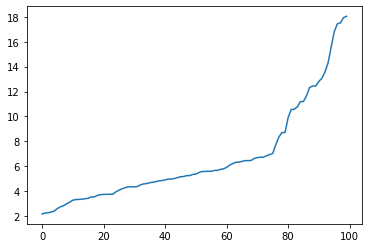

In [376]:
plot(ds[np.argsort(ds)])

In [355]:
ds[np.argsort(ds)][-7]

14.676666267226876

In [377]:
glom_sort = [gloms[i] for i in np.argsort(ds)]

In [378]:
glom_sort

['VM2_R',
 'VA3_R',
 'VA1d_L',
 'DM5_L',
 'VM6_L',
 'VM1_R',
 'D_R',
 'DM4_R',
 'DA2_L',
 'DM6_R',
 'VA5_L',
 'VA3_L',
 'VM7_L',
 'VL2p_R',
 'DL3_L',
 'DL5_L',
 'VM6_R',
 'VM1_L',
 'VM2_L',
 'VA2_R',
 'DA4m_L',
 'DL4_L',
 'DL1_L',
 'V_L',
 'VL2p_L',
 'VM3_R',
 'DM3_L',
 'DM6_L',
 'VA7l_R',
 'VA7l_L',
 'VA1d_R',
 'VM3_L',
 'DL3_R',
 'V_R',
 'VM5v_R',
 'VA2_L',
 'DA4m_R',
 'DM2_L',
 'DL2l_L',
 'DA4l_R',
 'DL2l_R',
 'VA7m_L',
 'VM5v_L',
 'DM1_L',
 'DM3_R',
 'VA1v_R',
 'DA1_L',
 'VL1_R',
 'DA3_R',
 'DM1_R',
 'VA4_L',
 'DM2_R',
 'D_L',
 'VA5_R',
 'VA6_R',
 'VA7m_R',
 'DA3_L',
 'VC4_L',
 'DM5_R',
 'VA4_R',
 'DA2_R',
 'VA1v_L',
 'VA6_L',
 'VL1_L',
 'DP1m_R',
 'DP1l_R',
 'DL4_R',
 'DL1_R',
 'VM5d_L',
 'DA1_R',
 'VM4_L',
 'VM4_R',
 'VM7_R',
 'VL2a_L',
 'VL2a_R',
 'DM4_L',
 'DP1m_L',
 'DL5_R',
 'DC3_R',
 'DA4l_L',
 'VC2_L',
 'DC1_L',
 'DC2_L',
 'DP1l_L',
 'VM5d_R',
 'VM7v_R',
 'VM7v_L',
 'DL2d_L',
 'DC2_R',
 'DC3_L',
 'DL2d_R',
 'VC2_R',
 'DC1_R',
 'VC1_R',
 'VC4_R',
 'VC1_L',
 'VC3_L',
 'DC4_L'

In [367]:
Z = 65
ds_test = np.zeros(100)
i_glom = 35
mask = (pnmask == i_glom+1)
sig = mask.astype(int)
sig_sum = np.sum(sig)
x_pnc = np.sum(np.sum(np.sum(sig, axis=0), axis=1) * np.arange(al_adult.X)) / sig_sum
y_pnc = np.sum(np.sum(np.sum(sig, axis=1), axis=1) * np.arange(al_adult.Y)) / sig_sum
sig_ = np.sum(np.sum(sig, axis=0), axis=0)[:Z]
z_pnc = np.sum(sig_ * np.arange(Z)) / np.sum(sig_)
side = 0 if (opm.glomid_list[i_glom][-1] is 'L') else 1
z0_ = np.floor(z_pnc).astype(int)
z1_ = np.ceil(z_pnc).astype(int)
x_pnc = x_pnc * xf
y_pnc = y_pnc * yf
z_pnc = z_pnc * zf
# ncad in z0 is larger than the one in z1
#         print(z0_, z1_)
z0, z1 = (z0_, z1_) if (al_adult.ncad[side][z0_].ab > al_adult.ncad[side][z1_].ab) else (z1_, z0_)
d0 =  np.min(np.sqrt((al_adult.ncad[side][z0].xb-x_pnc)**2+(al_adult.ncad[side][z0].yb-y_pnc)**2))
theta = np.arctan(al_adult.zf / ((al_adult.ncad[side][z0].ab - al_adult.ncad[side][z1].ab)/2))
d_ = d0 * np.sin(theta)
ds_test[i_glom] = np.min([d_,(z0-al_adult.ncadz[side][0])*zf])

In [370]:
opm.glomid_list[32]

'DL1_R'

In [368]:
ds_test[35]

14.676666267226876

In [337]:
np.min([10,3])

3

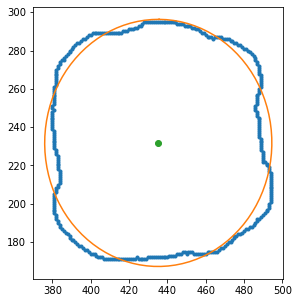

In [222]:
xb, yb = el.xb, el.yb
coeffs = im.fit_ellipse(xb, yb)
x0, y0, ap, bp, e, phi = im.cart_to_pol(coeffs)
# print('Fitted parameters:')
# print('a, b, c, d, e, f =', coeffs)
ax = ph.large_ax([5,5])
ax.plot(xb, yb, '.')     # given points
xf, yf = im.get_ellipse_pts((x0, y0, ap, bp, e, phi))
ax.plot(xf, yf)
ax.plot(x0,y0,'o')
ax.set_aspect('equal', 'box')

In [ ]:
a ~= b ~= 35

In [291]:
opm.glomid_list[0][-1] is 'L'

False

#### Numerically calculate the distance of PN center to AL

In [95]:
def solve(semi_major, semi_minor, p):  
    px = abs(p[0])
    py = abs(p[1])

    tx = 0.707
    ty = 0.707

    a = semi_major
    b = semi_minor

    for x in range(0,10):
        x = a * tx
        y = b * ty

        ex = (a*a - b*b) * tx**3 / a
        ey = (b*b - a*a) * ty**3 / b

        rx = x - ex
        ry = y - ey

        qx = px - ex
        qy = py - ey

        r = math.hypot(ry, rx)
        q = math.hypot(qy, qx)

        tx = min(1, max(0, (qx * r / q + ex) / a))
        ty = min(1, max(0, (qy * r / q + ey) / b))
        t = math.hypot(ty, tx)
        tx /= t 
        ty /= t 

    return (math.copysign(a * tx, p[0]), math.copysign(b * ty, p[1]))

px = x_pnc - x0
py = y_pnc - y0

theta = -phi
px_ = px * cos(theta) - py * sin(theta)
py_ = px * sin(theta) + py * cos(theta)
dx_, dy_ = solve(ap, bp, [px_, py_])

theta = phi
dx = dx_ * cos(theta) - dy_ * sin(theta) + x0
dy = dx_ * sin(theta) + dy_ * cos(theta) + y0

In [112]:
class t1():
    def __init__(self, a=1):
        self.a = 1
        
class t2():
    def __init__(self, b=2):
        self.append(t1(b))
        self.append(t1(b+1))